In [ ]:
!pip install kaggle

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors


In [ ]:
!unzip /content/tuberculosis-tb-chest-xray-dataset.zip

Archive:  /content/tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1009.png 

In [ ]:
import numpy as np
import pandas as ps
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import cv2
import io
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.utils import shuffle
from keras import layers,models,optimizers
import ipywidgets as widgets
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,Dropout,BatchNormalization,Concatenate,AveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from google.colab.patches import cv2_imshow

In [ ]:
labels=["Tuberculosis","Normal"]

In [ ]:
X=[]
Y=[]

In [ ]:
image_size=(227,227)

In [ ]:
for i in labels:
  path="/content/TB_Chest_Radiography_Database/"+i+"/"
  print(path)
  fileRead=glob.glob(path+"*")
  print(len(fileRead))

  for j in fileRead:
    image=cv2.imread(j)
    image=cv2.resize(image,image_size)
    X.append(image)
    Y.append(i)



/content/TB_Chest_Radiography_Database/Tuberculosis/
700
/content/TB_Chest_Radiography_Database/Normal/
3500


In [ ]:
X=np.array(X)
Y=np.array(Y)


In [ ]:
for i in labels:
  path="/content/TB_Chest_Radiography_Database/"+i+"/"
  print(path)
  fileRead=glob.glob(path+"*")
  print(fileRead[5])


/content/TB_Chest_Radiography_Database/Tuberculosis/
/content/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-76.png
/content/TB_Chest_Radiography_Database/Normal/
/content/TB_Chest_Radiography_Database/Normal/Normal-2679.png


In [ ]:
Temp_y = []
for i in Y:
    Temp_y.append(labels.index(i))


In [ ]:
Y = np.array(Temp_y)
Y = to_categorical(Y)

print(Y[0])

[1. 0.]


In [ ]:
optimizer = optimizers.Adam(learning_rate=0.0001)
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Concatenate

In [ ]:
resnet_X_train,resnet_X_test,resnet_Y_train,resnet_Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Activation

def resnet_block(model, filters, strides=(1, 1)):
    model.add(Conv2D(filters, (3, 3), strides=strides, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    return model

def resnet18_model(input_shape=(227, 227, 3)):
    model = Sequential()

    # Initial Convolution
    model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    # ResNet Blocks
    model = resnet_block(model, filters=64)
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    model = resnet_block(model, filters=128, strides=(2, 2))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    model = resnet_block(model, filters=256, strides=(2, 2))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    model = resnet_block(model, filters=512, strides=(2, 2))
    model.add(AveragePooling2D((1, 1)))  # Average pooling instead of max pooling
    model.add(Flatten())

    # Classification Head
    model.add(Dense(len(labels), activation='softmax'))

    return model

# Create the ResNet-18 model
resnet = resnet18_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
resnet.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
early_stopping=EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
resnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 114, 114, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 114, 114, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 114, 114, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       590,08

 Total params: 4,738,946 (18.08 MB)

 Trainable params: 4,734,978 (18.06 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
resnet_history=resnet.fit(resnet_X_train,resnet_Y_train, validation_data=(resnet_X_test,resnet_Y_test),epochs=10,batch_size=32,verbose=1)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.8921 - loss: 0.2674 - val_accuracy: 0.9036 - val_loss: 0.6169
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9907 - loss: 0.0384 - val_accuracy: 0.2857 - val_loss: 0.9307
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9936 - loss: 0.0233 - val_accuracy: 0.8393 - val_loss: 0.3646
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9954 - loss: 0.0186 - val_accuracy: 0.9679 - val_loss: 0.0992
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9903 - loss: 0.0258 - val_accuracy: 0.9333 - val_loss: 0.2317
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9985 - loss: 0.0078 - val_accuracy: 0.9798 - val_loss: 0.0634
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9980 - loss: 0.0085 - val_accuracy: 0.9881 - val_loss: 0.0448
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9957 - loss: 0.0132 - val_acc

In [ ]:
train_loss = resnet_history.history['loss']
train_accuracy = resnet_history.history['accuracy']
test_loss = resnet_history.history['val_loss']
test_accuracy = resnet_history.history['val_accuracy']
epochs = range(1, len(train_loss)+1)


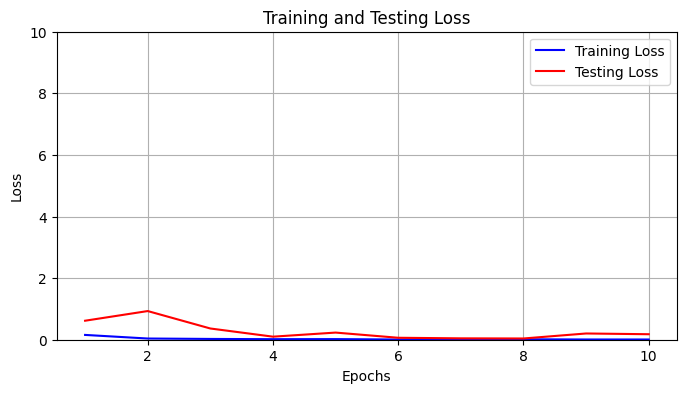

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,10)
plt.legend()
plt.grid(True)
plt.show()

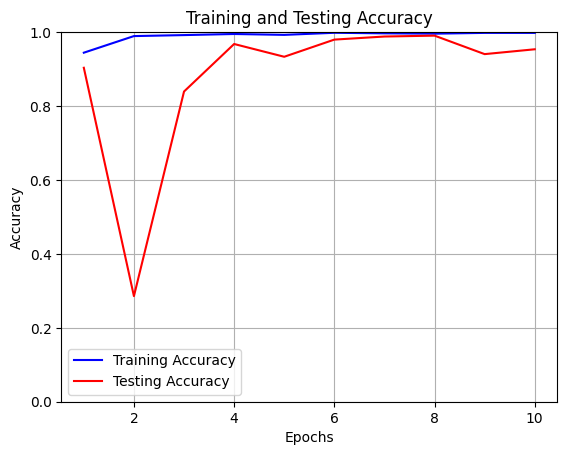

In [ ]:
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, test_accuracy, 'r', label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


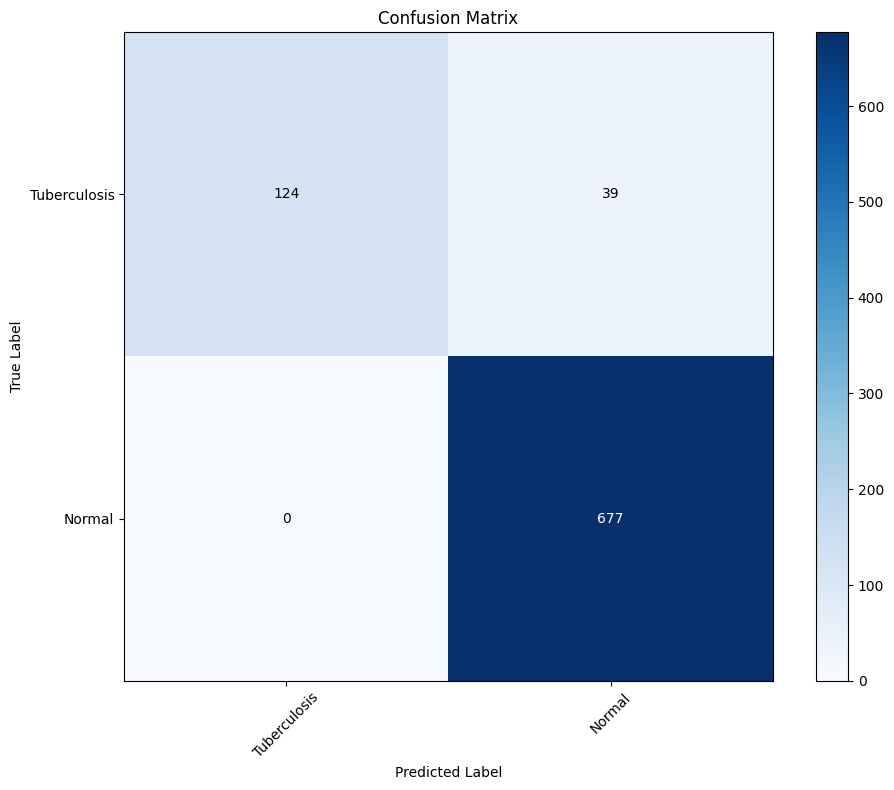

In [ ]:
y_pred = resnet.predict(resnet_X_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(resnet_Y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


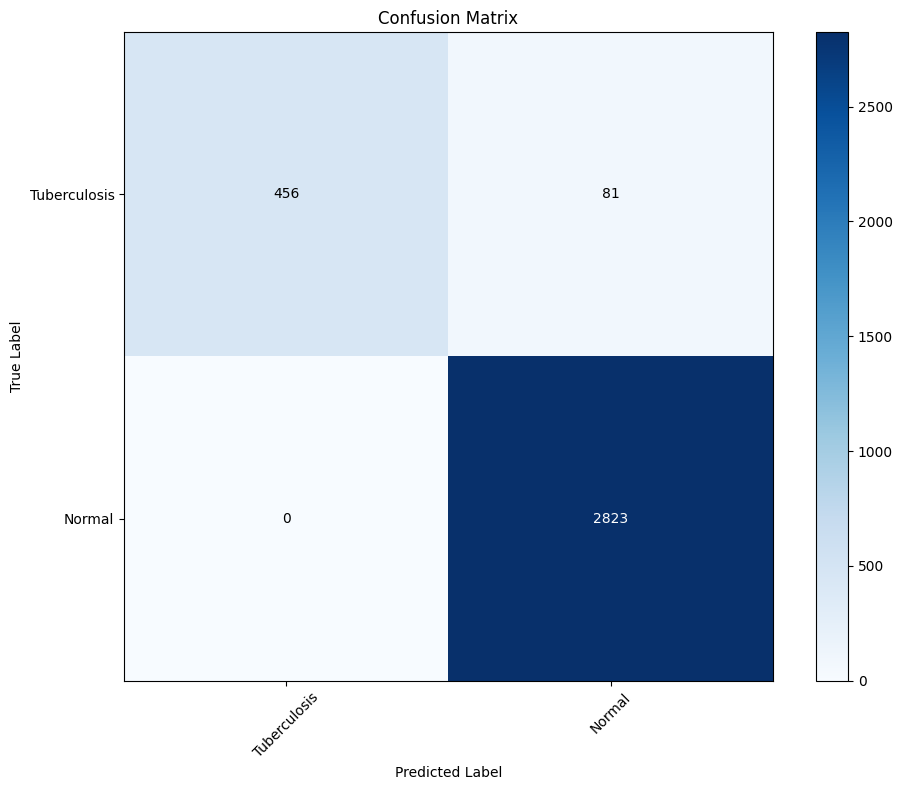

In [ ]:
y_pred = resnet.predict(resnet_X_train)

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(resnet_Y_train, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
def resnet_pred(path):
  img_path = path
  img = image.load_img(img_path, target_size=(227, 227))
  img_array = image.img_to_array(img)
  img_tensor = np.expand_dims(img_array, axis=0)
  img_tensor = img_tensor / 255.0
  prediction = resnet.predict(img_tensor)
  predicted_class_index = np.argmax(prediction)
  predicted_class_name = labels[predicted_class_index]
  imge=cv2.imread(path)
  cv2_imshow(imge)
  print('Predicted class:', predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


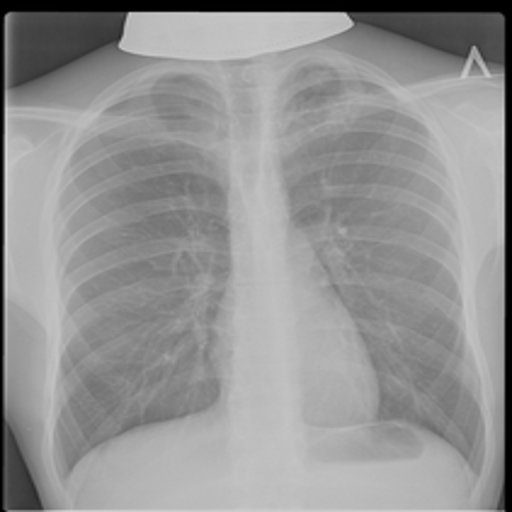

Predicted class: Tuberculosis


In [ ]:
resnet_pred('/content/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-102.png')

# Applying the XAI techniques for the understanding

In [ ]:
i=0
for layer in resnet.layers:
    print(i,layer.name)
    i+=1

0 conv2d
1 batch_normalization
2 activation
3 max_pooling2d
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d_1
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_2
18 conv2d_5
19 batch_normalization_5
20 activation_5
21 conv2d_6
22 batch_normalization_6
23 activation_6
24 max_pooling2d_3
25 conv2d_7
26 batch_normalization_7
27 activation_7
28 conv2d_8
29 batch_normalization_8
30 activation_8
31 average_pooling2d
32 flatten
33 dense


In [ ]:
for layer in resnet.layers:
    if 'conv' in layer.name:
        print(layer.name)


conv2d
conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_5
conv2d_6
conv2d_7
conv2d_8


In [ ]:
resnet.layers[28]

<Conv2D name=conv2d_8, built=True>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2


In [ ]:
def get_gradcam_heatmap(model, image, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
def display_gradcam(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()
